In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

os.environ['KERAS_BACKEND'] = 'torch'
import bayesflow as bf

from bayesflow import diagnostics

from diffusion_model import ScoreModel, SDE, train_score_model, count_parameters

with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


In [2]:
torch_device = torch.device("cuda")

In [3]:
def draw_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [ ]:
simulator = bf.make_simulator([draw_prior, forward_model])

# BayesFlow Baseline

In [ ]:
from nils_diffusion import DenoisingDiffusion

In [ ]:
offline_set = simulator.sample(64*512)
valid_set = simulator.sample(64*128)

In [ ]:
workflow = bf.BasicWorkflow(
    #inference_network=bf.networks.FlowMatching(
    #    subnet="mlp",
    #    subnet_kwargs={"dropout": 0.0, "widths": (256,)*6}
    #),
    inference_network=DenoisingDiffusion(),
    #summary_network=ShallowSetBF(),
    inference_variables=["theta"],
    inference_conditions=["x"],
    simulator=simulator,
    #checkpoint_filepath="checkpoint_test.ckpt",
)

history = workflow.fit_offline(epochs=50, batch_size=64, data=offline_set, validation_data=valid_set)

In [ ]:
#workflow.plot_default_diagnostics(test_data=100, calibration_ecdf_kwargs={"difference": True});

In [ ]:
# Obtain samples from amortized posterior
conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}

# Obtain samples
samples = workflow.sample(conditions=conditions, num_datasets=1, num_samples=3000)["theta"]

f, ax = plt.subplots(1, 1, figsize=(15, 6))

# Plot samples
ax.scatter(samples[0, :, 0], samples[0, :, 1])
#sns.despine(ax=ax)
#ax.set_title(f"{name}", fontsize=16)
ax.grid(alpha=0.3)
ax.set_aspect("equal", adjustable="box")
#ax.set_xlim([-0.5, 0.5])
#ax.set_ylim([-0.5, 0.5])
ax.set_xlabel(r"$\theta_1$", fontsize=15)
ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()

# Score Matching

In [5]:
class Prior:
    def __init__(self):
        self.n_params_global = 2
        self.n_params_local = 0  # not a hierarchical model
        self.param_names = ['theta1', 'theta2']

        np.random.seed(0)
        sample_dict = simulator.sample(1000)
        thetas_global = torch.tensor(sample_dict['theta'], dtype=torch.float32)

        self.norm_x_mean = torch.zeros(2, dtype=torch.float32) #torch.tensor(np.mean(sample_dict['obs'], axis=(0,1)), dtype=torch.float32)
        self.norm_x_std = torch.ones(2, dtype=torch.float32) #torch.tensor(np.std(sample_dict['obs'], axis=(0,1)), dtype=torch.float32)
        self.norm_prior_global_mean = torch.mean(thetas_global, dim=0)
        self.norm_prior_global_std = torch.std(thetas_global, dim=0)
        self.current_device = 'cpu'

    def normalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return (theta - self.norm_prior_global_mean) / self.norm_prior_global_std
        raise ValueError('This is not a hierarchical model.')

    def denormalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return theta * self.norm_prior_global_std + self.norm_prior_global_mean
        raise ValueError('This is not a hierarchical model.')

    def normalize_data(self, x):
        self._move_to_device(x.device)
        return (x - self.norm_x_mean) / self.norm_x_std

    def _move_to_device(self, device):
        if self.current_device != device:
            print(f"Moving prior to device: {device}")
            self.norm_prior_global_mean = self.norm_prior_global_mean.to(device)
            self.norm_prior_global_std = self.norm_prior_global_std.to(device)
            self.norm_x_mean = self.norm_x_mean.to(device)
            self.norm_x_std = self.norm_x_std.to(device)
            self.current_device = device
        return

from diffusion_model.helper_functions import generate_diffusion_time
class DiffusionProblem(Dataset):
    def __init__(self, n_data, prior, sde, online_learning=False, rectified_flow=False):
        # Create model and dataset
        self.prior = prior
        self.sde = sde
        self.n_data = n_data
        self.online_learning = online_learning
        self.rectified_flow = rectified_flow
        self._generate_data()
        self._generate_diffusion_target()

    def _generate_data(self):
        # Create model and dataset
        sample_dict = simulator.sample(self.n_data)
        self.thetas_global_unnormalized = torch.tensor(sample_dict['theta'], dtype=torch.float32)
        self.thetas_global = self.prior.normalize_theta(self.thetas_global_unnormalized, global_params=True)
        self.xs_unnormalized = torch.tensor(sample_dict['x'], dtype=torch.float32)
        self.xs = self.prior.normalize_data(self.xs_unnormalized)

        # generate new noise only with new data
        if self.rectified_flow:
            self.noise = torch.randn_like(self.thetas_global)

    def _generate_diffusion_target(self):
        # Generate diffusion time and training target
        self.diffusion_time = generate_diffusion_time(size=self.n_data, return_batch=True)
        #self.diffusion_time = torch.tensor(np.random.choice(np.linspace(0, 1, num=1001), size=self.n_data).reshape(self.n_data, 1),
        #                                    dtype=torch.float32)

        # perturb the theta batch
        snr = self.sde.get_snr(t=self.diffusion_time)
        self.alpha, self.sigma = self.sde.kernel(log_snr=snr)

        # generate new noise in each epoch
        if not self.rectified_flow:
            self.noise = torch.randn_like(self.thetas_global)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.thetas_global)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        params = self.thetas_global[idx]
        noise = self.noise[idx]

        param_noisy = self.alpha[idx] * params + self.sigma[idx] * noise
        return param_noisy, noise, self.xs[idx], self.diffusion_time[idx]

    def on_epoch_end(self):  # for online learning
        # Regenerate data at the end of each epoch
        if self.online_learning:
            self._generate_data()
        self._generate_diffusion_target()

    def on_batch_end(self):
        pass

In [6]:
batch_size = 64
prior = Prior()
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0],
)

Kernel type: variance_preserving, noise schedule: linear
t_min: 0.0005980199202895164, t_max: 3.872983455657959
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))


In [7]:
dataset = DiffusionProblem(
    n_data=64*512,
    prior=prior,
    sde=current_sde,
    online_learning=False
)
dataset_valid = DiffusionProblem(
    n_data=64*128,
    prior=prior,
    sde=current_sde,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

Moving prior to device: cpu


In [8]:
for test in dataloader:
    params, target, data, time = test
    print(params.shape, target.shape, data.shape, time.shape)
    #print(time)
    #print(summary_net(data).shape)
    break

torch.Size([64, 2]) torch.Size([64, 2]) torch.Size([64, 2]) torch.Size([64, 1])


In [9]:
from diffusion_model.helper_networks import GaussianFourierProjection
time_embedding = nn.Sequential(
    GaussianFourierProjection(embed_dim=8),
    nn.Linear(8, 8),
    nn.Mish()
)

# Define diffusion model
score_model = ScoreModel(
    input_dim_theta=prior.n_params_global,
    input_dim_x=2,
    #time_embedding=time_embedding,
    #summary_net=ShallowSet(dim_input=2, dim_output=8),
    hidden_dim=256,
    n_blocks=5,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    prior=prior,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][0],
    name_prefix='diffusion_',
    full_res_layer=True
)
count_parameters(score_model)
print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|       projection_layer.weight        |    512     |
|        projection_layer.bias         |    256     |
|   blocks.res_blocks.0.dense.weight   |    1280    |
|    blocks.res_blocks.0.dense.bias    |    256     |
| blocks.res_blocks.0.projector.weight |    1280    |
|   blocks.res_blocks.1.dense.weight   |   65536    |
|    blocks.res_blocks.1.dense.bias    |    256     |
|   blocks.res_blocks.2.dense.weight   |   65536    |
|    blocks.res_blocks.2.dense.bias    |    256     |
|   blocks.res_blocks.3.dense.weight   |   65536    |
|    blocks.res_blocks.3.dense.bias    |    256     |
|   blocks.res_blocks.4.dense.weight   |   65536    |
|    blocks.res_blocks.4.dense.bias    |    256     |
|    final_projection_linear.weight    |    512     |
|     final_projection_linear.bias     |     2      |
+---------------------------

Training v-model for 50 epochs with learning rate 0.0005 and None weighting.


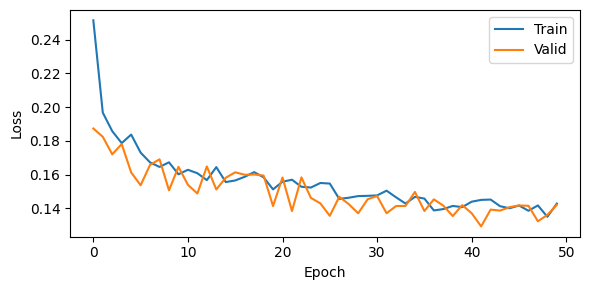

In [10]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=50, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Train')
plt.plot(loss_history[:, 1], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

## Sampling

In [16]:
from diffusion_model import langevin_sampling, adaptive_sampling, euler_maruyama_sampling

In [17]:
n_post_samples = 1000

dataset_test = DiffusionProblem(
    n_data=100,
    prior=prior,
    sde=current_sde,
)

valid_data = dataset_test.xs_unnormalized
valid_prior = dataset_test.thetas_global_unnormalized
param_names = prior.param_names

In [18]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                        #mini_batch_arg=mini_batch_arg,
                                                        diffusion_steps=1000,
                                                        device=torch_device, verbose=True)

# posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
#                                                     #mini_batch_arg=mini_batch_arg,
#                                                     diffusion_steps=100, langevin_steps=5, step_size_factor=0.05,
#                                                     device=torch_device, verbose=True)

#posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples=n_post_samples,
#                                                   #mini_batch_arg=mini_batch_arg,
#                                                   run_sampling_in_parallel=False,
#                                                   device=torch_device, verbose=False)

Moving prior to device: cuda:0


100%|██████████| 1000/1000 [00:05<00:00, 183.02it/s]


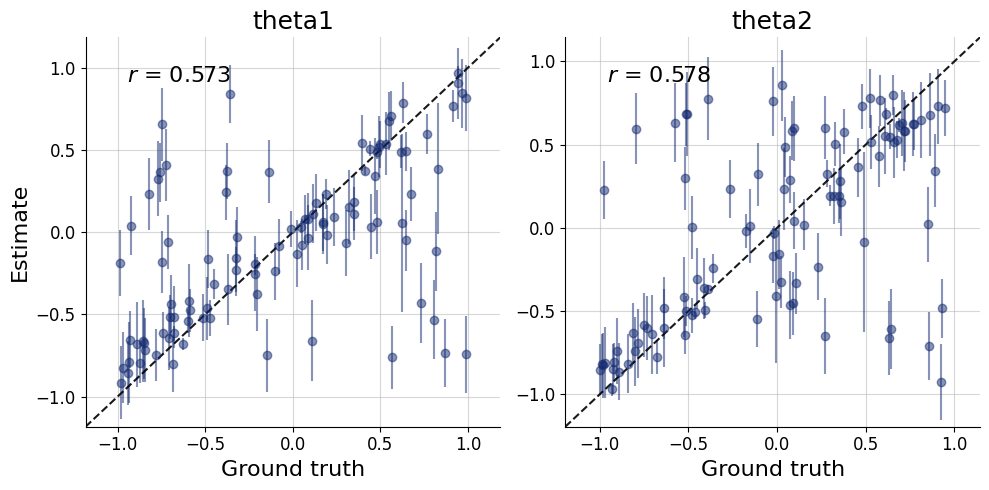

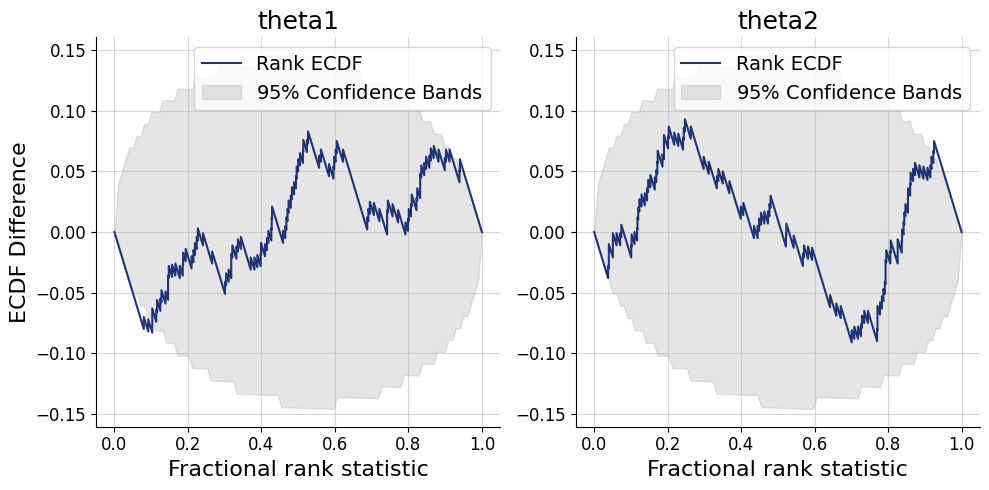

In [19]:
diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior), variable_names=param_names)
diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior),
                             difference=True, variable_names=param_names);

In [20]:
valid_data = torch.tensor([[0, 0]], dtype=torch.float32)
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                        #mini_batch_arg=mini_batch_arg,
                                                        diffusion_steps=1000,
                                                        device=torch_device, verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 2625.70it/s]


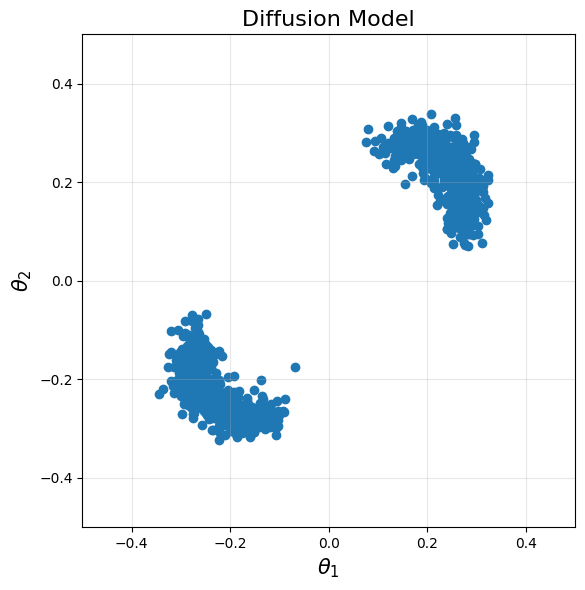

In [21]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))

# Plot samples
ax.scatter(posterior_global_samples_valid[0, :, 0], posterior_global_samples_valid[0, :, 1])
#sns.despine(ax=ax)
ax.set_title(f"Diffusion Model", fontsize=16)
ax.grid(alpha=0.3)
ax.set_aspect("equal", adjustable="box")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel(r"$\theta_1$", fontsize=15)
ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()